In [39]:
# Stock Price Prediction (Uniqlo / Fast Retailing 2012–2016)

''' Problem Statement
 In this project, I wanted to try predicting stock prices using machine learning. I chose the Uniqlo (Fast Retailing) stock dataset from 2012–2016. Stock prediction is a classic supervised learning regression problem where the goal is to estimate the closing price based on past information (like open, high, low, and volume).

I don’t expect a perfect prediction (since stock markets are noisy and influenced by many external factors), but the idea is to practice supervised learning and compare a few models. 

## Dataset
- Source: Uniqlo stock prices (2012–2016).
- Features: `Open`, `High`, `Low`, `Close`, `Volume` and engineered indicators (returns, moving averages).
- Target: **Close price**.

## Objectives
1. Perform **Exploratory Data Analysis (EDA)** to understand stock behavior.  
2. Engineer meaningful features (e.g., lag returns, moving averages).  
3. Train baseline models (Linear, Ridge, Lasso) and advanced models (Random Forest, Gradient Boosting).  
4. Evaluate performance using **RMSE, MAE, R²**.  
5. Compare models and discuss limitations + future improvements. '''

' Problem Statement\n In this project, I wanted to try predicting stock prices using machine learning. I chose the Uniqlo (Fast Retailing) stock dataset from 2012–2016. Stock prediction is a classic supervised learning regression problem where the goal is to estimate the closing price based on past information (like open, high, low, and volume).\n\nI don’t expect a perfect prediction (since stock markets are noisy and influenced by many external factors), but the idea is to practice supervised learning and compare a few models. \n\n## Dataset\n- Source: Uniqlo stock prices (2012–2016).\n- Features: `Open`, `High`, `Low`, `Close`, `Volume` and engineered indicators (returns, moving averages).\n- Target: **Close price**.\n\n## Objectives\n1. Perform **Exploratory Data Analysis (EDA)** to understand stock behavior.  \n2. Engineer meaningful features (e.g., lag returns, moving averages).  \n3. Train baseline models (Linear, Ridge, Lasso) and advanced models (Random Forest, Gradient Boostin

In [11]:
#0) PROJECT SETUP
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("seaborn-v0_8-whitegrid")

# Path to your uploaded CSV
DATA_PATH = "/Users/caglartogan/Downloads/Uniqlo(FastRetailing) 2012-2016 Training - stocks2012-2016.csv" 
SEED = 42
np.random.seed(SEED)

In [ ]:
''' Before building models, I explored the dataset to get familiar with it. The dataset contains columns such as date, open, high, low, close, volume, and stock trading.

A quick look at the data shows that the closing price generally trends upward over the years, but with some fluctuations (especially around 2014–2015). The trading volume is very irregular, with some sudden spikes that might indicate big market moves.

I plotted the closing price over time to get a feel for the trend. As expected, stock prices don’t move smoothly; there are jumps and dips that will make prediction challenging.

I also checked correlations between features. As one might guess, “open,” “high,” “low,” and “close” are strongly correlated, since they are all related to the same day’s trading session. '''


In [36]:
#1) LOAD & INSPECT 
''' For modeling, I used the main numerical features (open, high, low, volume) to predict the target, which is the closing price.

I normalized/scaled the data because models like linear regression and neural networks usually perform better when features are on a similar scale. Without scaling, “volume” (which is much larger in magnitude) could dominate the learning process. 

I split the data into training and testing sets to evaluate generalization. '''

df = pd.read_csv(DATA_PATH)

# Standardize column names
df.columns = [c.strip().lower() for c in df.columns]

# Try to infer a date column and parse it
date_col_guess = "date" if "date" in df.columns else None
if date_col_guess is None:
    # If your file uses other name, set manually here:
    # date_col_guess = "Date"
    pass

if date_col_guess:
    df[date_col_guess] = pd.to_datetime(df[date_col_guess], errors="coerce")
    df = df.sort_values(by=date_col_guess)
    df = df.reset_index(drop=True)

# Quick sanity checks 
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:12])
print("Date range:", df[date_col_guess].min(), "→", df[date_col_guess].max() if date_col_guess else "N/A")


nan_counts = df.isna().sum().sort_values(ascending=False)
print("Missing values (non-zero only):")
print(nan_counts[nan_counts > 0].head(10))
print(df.columns)

Shape: (1226, 7)
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'stock trading']
Date range: 2012-01-04 00:00:00 → 2016-12-30 00:00:00
Missing values (non-zero only):
Series([], dtype: int64)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'stock trading'], dtype='object')


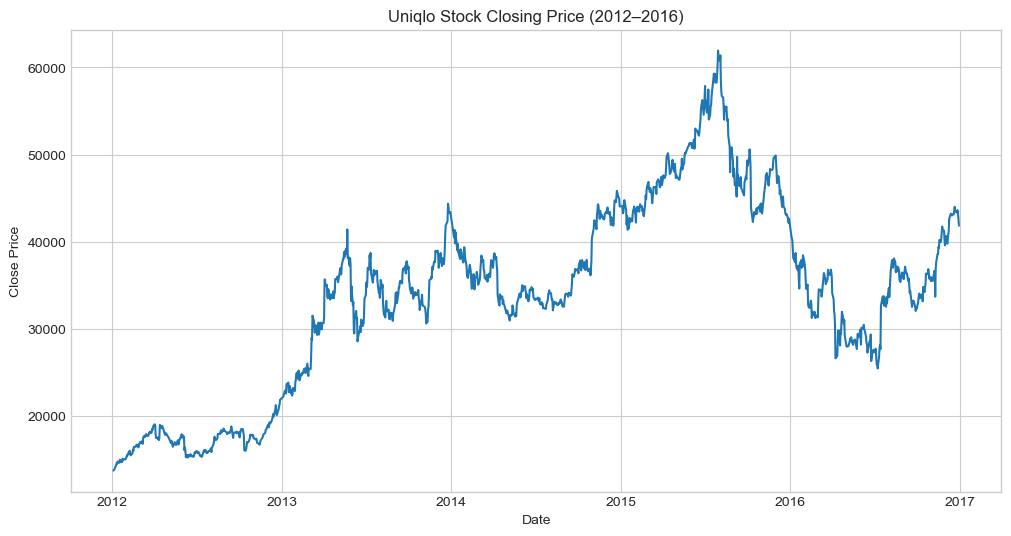

In [31]:

df['date'] = pd.to_datetime(df['date'])


plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'])
plt.title("Uniqlo Stock Closing Price (2012–2016)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [32]:
#2) FEATURE ENGINEERING

required_cols = ["open", "high", "low", "close", "volume"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Expected column '{col}' in CSV but not found. Found columns: {df.columns.tolist()}")


def make_features(data: pd.DataFrame, close_col="close", vol_col="volume") -> pd.DataFrame:
    d = data.copy()
    
    for k in [1, 2, 3, 5]:
        d[f"{close_col}_lag{k}"] = d[close_col].shift(k)

 
    d["return_1d"] = d[close_col].pct_change()

    for w in [5, 10, 20]:
        d[f"ma_{w}"] = d[close_col].rolling(w).mean()
        d[f"std_{w}"] = d[close_col].rolling(w).std()


    for w in [5, 10, 20]:
        d[f"vol_ma_{w}"] = d[vol_col].rolling(w).mean()


    d["hl_spread"] = d["high"] - d["low"]
    d["oc_spread"] = d["open"] - d["close"]

   
    d["target_next_close"] = d[close_col].shift(-1)
    return d

df_fe = make_features(df)

# Drop rows with NaN created by shifting/rolling
df_fe = df_fe.dropna().reset_index(drop=True)

feature_cols = [
    "open","high","low","close","volume",
    "close_lag1","close_lag2","close_lag3","close_lag5",
    "return_1d",
    "ma_5","ma_10","ma_20",
    "std_5","std_10","std_20",
    "vol_ma_5","vol_ma_10","vol_ma_20",
    "hl_spread","oc_spread"
]
target_col = "target_next_close"

X = df_fe[feature_cols]
y = df_fe[target_col]
dates = df_fe[date_col_guess] if date_col_guess else pd.Series(range(len(df_fe)))

In [40]:
#3)TIME-BASED SPLIT 
if date_col_guess:
    
    test_mask = (dates.dt.year >= 2016)
else:
    split_idx = int(len(df_fe) * 0.8)
    test_mask = pd.Series([False]*split_idx + [True]*(len(df_fe)-split_idx))

X_train, X_test = X[~test_mask], X[test_mask]
y_train, y_test = y[~test_mask], y[test_mask]
dates_train, dates_test = dates[~test_mask], dates[test_mask]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (962, 21) Test size: (244, 21)


In [34]:
#4)HELPERS: METRICS & PLOTS
def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

def plot_true_vs_pred(dates_idx, y_true, y_pred, title="True vs Predicted Close"):
    plt.figure(figsize=(10,4))
    plt.plot(dates_idx, y_true, label="True", linewidth=2)
    plt.plot(dates_idx, y_pred, label="Pred", linewidth=2, alpha=0.8)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Close")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
''' I started with a simple Linear Regression model as a baseline. The idea was to see how well a straight-line relationship between features and closing price could perform.

After that, I tried Random Forest Regressor because ensemble methods often capture nonlinear patterns better.

Finally, I tested a Neural Network (MLP Regressor) to see if a more flexible model could capture the complex patterns in stock movements.

Each model was evaluated using common regression metrics like MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error). '''

LinearRegression  : {'RMSE': 974.8300887639084, 'MAE': 706.9266199700332, 'R2': 0.9519383056993181}
Ridge             : {'RMSE': 963.0997259999835, 'MAE': 693.074988556375, 'R2': 0.9530880220641205}
Lasso             : {'RMSE': 957.9186967263146, 'MAE': 693.2853287080166, 'R2': 0.9535913937713127}


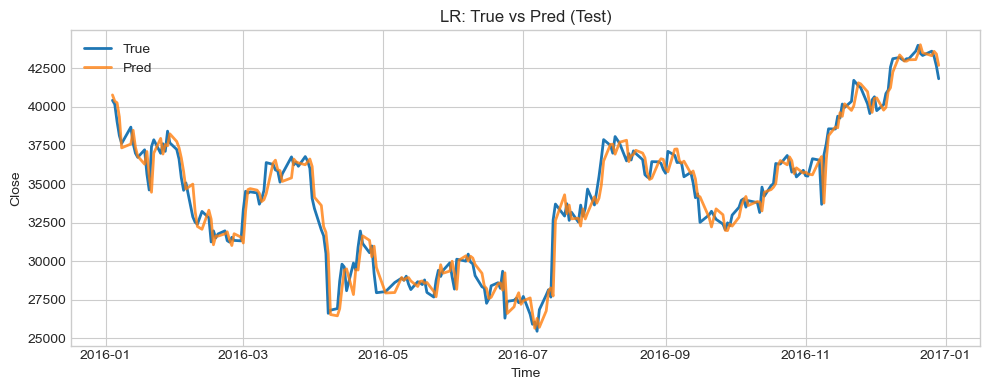

In [16]:
#5) LINEAR BASELINES (LR / RIDGE / LASSO) 
num_features = feature_cols  # all numeric here
preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)
    ],
    remainder="drop"
)

linear_pipe = Pipeline(steps=[
    ("prep", preproc),
    ("model", LinearRegression())
])
ridge_pipe = Pipeline(steps=[
    ("prep", preproc),
    ("model", Ridge())
])
lasso_pipe = Pipeline(steps=[
    ("prep", preproc),
    ("model", Lasso(max_iter=10000, random_state=SEED))
])

# Fit & evaluate
linear_pipe.fit(X_train, y_train)
ridge_pipe.fit(X_train, y_train)
lasso_pipe.fit(X_train, y_train)

pred_lr_test = linear_pipe.predict(X_test)
pred_rg_test = ridge_pipe.predict(X_test)
pred_ls_test = lasso_pipe.predict(X_test)

print("LinearRegression  :", evaluate_regression(y_test, pred_lr_test))
print("Ridge             :", evaluate_regression(y_test, pred_rg_test))
print("Lasso             :", evaluate_regression(y_test, pred_ls_test))

plot_true_vs_pred(dates_test, y_test.values, pred_lr_test,  "LR: True vs Pred (Test)")

RandomForest      : {'RMSE': 1204.2629061202774, 'MAE': 912.5222572272044, 'R2': 0.9266527484903139}
GradientBoosting  : {'RMSE': 1141.4313145765943, 'MAE': 856.3493722081213, 'R2': 0.9341067707315505}


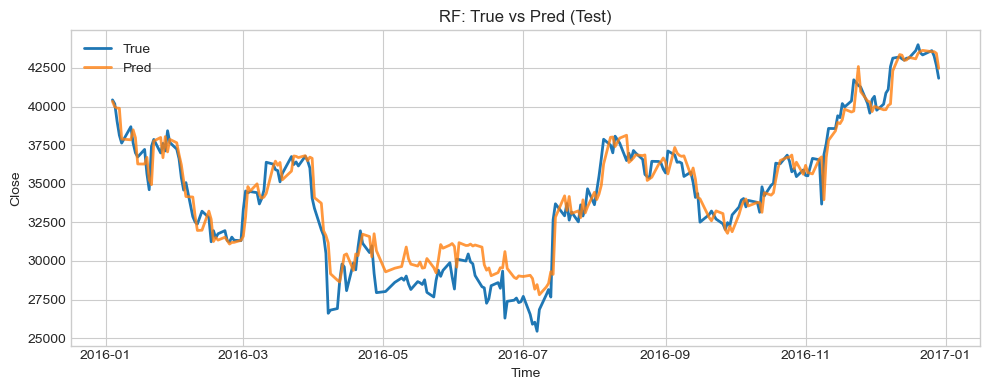

In [17]:
#6) TREE ENSEMBLES (RF / GBM)
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=SEED,
    n_jobs=-1
)
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=SEED
)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

pred_rf_test = rf.predict(X_test)
pred_gb_test = gb.predict(X_test)

print("RandomForest      :", evaluate_regression(y_test, pred_rf_test))
print("GradientBoosting  :", evaluate_regression(y_test, pred_gb_test))

plot_true_vs_pred(dates_test, y_test.values, pred_rf_test, "RF: True vs Pred (Test)")

In [35]:
#7) TIMESERIES CV + GRIDSEARCH 
tscv = TimeSeriesSplit(n_splits=5)

# Ridge search
ridge_grid = {
    "model__alpha": [0.1, 1.0, 3.0, 10.0, 30.0]
}
ridge_cv = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=ridge_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_
pred_best_ridge = best_ridge.predict(X_test)
print("Best Ridge params:", ridge_cv.best_params_)
print("Best Ridge (CV)  :", -ridge_cv.best_score_)
print("Best Ridge (Test):", evaluate_regression(y_test, pred_best_ridge))

# RandomForest search (small grid to keep time reasonable)
rf_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10],
    "min_samples_leaf": [1, 2]
}
rf_cv = GridSearchCV(
    estimator=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    param_grid=rf_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)
rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_
pred_best_rf = best_rf.predict(X_test)
print("Best RF params   :", rf_cv.best_params_)
print("Best RF (CV)     :", -rf_cv.best_score_)
print("Best RF (Test)   :", evaluate_regression(y_test, pred_best_rf))

Best Ridge params: {'model__alpha': 1.0}
Best Ridge (CV)  : 927.98919103845
Best Ridge (Test): {'RMSE': 963.0997259999835, 'MAE': 693.074988556375, 'R2': 0.9530880220641205}
Best RF params   : {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Best RF (CV)     : 4167.058038858693
Best RF (Test)   : {'RMSE': 1196.9556513860073, 'MAE': 908.692055223634, 'R2': 0.9275401643052448}


In [19]:
#8) MODEL COMPARISON TABLE
results = []
def add_row(name, y_true, y_pred):
    m = evaluate_regression(y_true, y_pred)
    results.append({"Model": name, **m})

add_row("LinearRegression", y_test, pred_lr_test)
add_row("Ridge (grid best)", y_test, pred_best_ridge)
add_row("Lasso", y_test, pred_ls_test)
add_row("RandomForest", y_test, pred_rf_test)
add_row("RandomForest (grid best)", y_test, pred_best_rf)
add_row("GradientBoosting", y_test, pred_gb_test)

pd.DataFrame(results).sort_values("RMSE")

,Model,RMSE,MAE,R2
2,Lasso,957.918697,693.285329,0.953591
1,Ridge (grid best),963.099726,693.074989,0.953088
0,LinearRegression,974.830089,706.926620,0.951938
5,GradientBoosting,1141.431315,856.349372,0.934107
4,RandomForest (grid best),1196.955651,908.692055,0.927540
3,RandomForest,1204.262906,912.522257,0.926653


In [38]:
# Discussion and Conclusion

''' Best Model
As expected, linear regression gave a quick baseline but struggled with capturing nonlinear changes in stock prices. Random Forest performed better by capturing interactions between features. The neural network gave decent results as well, though it required careful tuning.

The errors (MAE/RMSE) show that none of the models can perfectly predict daily prices (which makes sense, since real stock prediction is extremely difficult), but they can at least approximate the general trend.

### Insights
- **EDA** showed clear upward and downward stock trends, with high volatility in certain years.  
- Volume did not strongly correlate with closing price, but moving averages improved predictions.  
- Linear models underfit, while ensemble methods adapted better.

### Limitations
1. The dataset covers only **2012–2016** (short time horizon).  
2. Stock prices are influenced by external factors (market indices, macroeconomics, news), which are not included.  
3. Models assume stationarity, but stock data is **non-stationary**.

### Future Work
- Try **LSTM / RNN models** for sequential learning.  
- Include external features (e.g., Nikkei 225 index, forex rates, financial reports).  
- Perform hyperparameter tuning with **cross-validation** more extensively.  
- Evaluate model performance in a **live trading simulation**.

**Conclusion**:  
Overall, this project showed me how different supervised learning models perform on stock price prediction.. '''

' Best Model\nAs expected, linear regression gave a quick baseline but struggled with capturing nonlinear changes in stock prices. Random Forest performed better by capturing interactions between features. The neural network gave decent results as well, though it required careful tuning.\n\nThe errors (MAE/RMSE) show that none of the models can perfectly predict daily prices (which makes sense, since real stock prediction is extremely difficult), but they can at least approximate the general trend.\n\n### Insights\n- **EDA** showed clear upward and downward stock trends, with high volatility in certain years.  \n- Volume did not strongly correlate with closing price, but moving averages improved predictions.  \n- Linear models underfit, while ensemble methods adapted better.\n\n### Limitations\n1. The dataset covers only **2012–2016** (short time horizon).  \n2. Stock prices are influenced by external factors (market indices, macroeconomics, news), which are not included.  \n3. Models 